En este trabajo vamos a implementar el modelo SCIR desarrollado en el paper : https://arxiv.org/pdf/2004.08842v2.pdf , en el paper se hace referencia al respositorio https://github.com/mariocastro73/predictability. Este repositorio tiene


https://arxiv.org/pdf/2004.08842v2.pdf




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange)

from scipy.integrate import odeint
import numpy as np
from datetime import datetime
import seaborn as sns
%matplotlib inline
import arviz as az
import urllib.request
import pymc3 as pm
import theano.tensor as tt
import warnings;
warnings.filterwarnings('ignore');

In [2]:
path_datos='https://github.com/alfonsotwr/snippets/blob/master/covidia-cam/madrid-series.csv?raw=true'

In [116]:
df = pd.read_csv(path_datos,parse_dates=['Fecha'],date_parser=lambda d: pd.to_datetime(d, format="%Y/%m/%d", errors="coerce"))

In [117]:
df.columns

Index(['Fecha', 'CASOS_PCR', 'Hospitalizados', 'UCI', 'Fallecidos',
       'Recuperados', 'domicilio', 'uci_dia', 'hospitalizados_dia',
       'domicilio_dia', 'altas_dia', 'fallecidos_dia', 'muertos_hospitales',
       'muertos_domicilios', 'muertos_centros', 'muertos_otros', 'muertos'],
      dtype='object')

In [118]:
df[['Fecha','CASOS_PCR','muertos','Recuperados']]

,Fecha,CASOS_PCR,muertos,Recuperados
0,2020-04-22,56245,11852,33032
1,2020-04-23,57094,12056,33645
2,2020-04-24,58191,12252,34212
3,2020-04-25,58819,12612,34902
4,2020-04-26,59126,12855,35367
...,...,...,...,...
123,2020-09-14,174835,15759,48615
124,2020-09-15,178491,15759,48867
125,2020-09-16,181924,15920,49170
126,2020-09-17,186826,15920,49427


In [165]:
fecha_inicio=datetime(year=2020,month=8,day=15)

df = df.fillna(0,axis=1)
df = df[(df['Fecha']>=fecha_inicio)]

color_avg = 'darkred'
color_titulos = 'navy'
color_diarios = 'royalblue'

df['infected'] = df['CASOS_PCR']-df['muertos']-df['Recuperados']

df['X'] = df['muertos']+df['Recuperados']
#df['X'] = df['X'].diff().rolling(window=7).mean()
df['X'] = df['X'].diff()

infected = np.array(df['infected'][1:])
infected_log = np.log(infected)
X = np.array(df['X'])[1:]
X_log = np.log(X)
t=np.array([i for i in range(len(infected))])

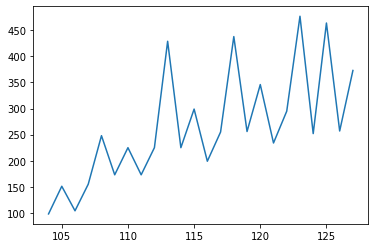

In [166]:
df['X'].plot()

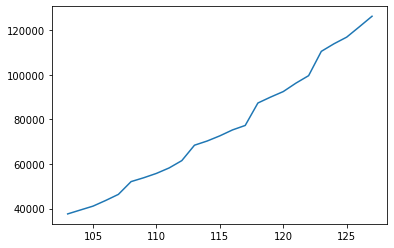

In [167]:
df['infected'].plot()

In [168]:
with pm.Model() as model:
    #t = pm.Data('tiempo',range(len(casos_nuevos)))
    t_ = t
    beta = pm.Uniform('beta',lower=0,upper=1)
    r_mu = pm.Uniform('r_mu',lower=0,upper=1)
    #p = pm.Uniform('p',lower=0,upper=5)
    #q = pm.Uniform('q',lower=0,upper=5)
    
    sigma_I = 1/tt.sqrt(pm.Gamma(name='sigmaI',alpha=0.01,beta=0.01))
    
    #R0 = pm.Deterministic('R0',beta/r_mu)
    #R0_ = pm.Deterministic('R0_',beta/r_mu)
    #media = pm.Deterministic('media',casos_acumulados_log[0]+(R0_-1)*(r_mu)*t_)
    
    #R0 = beta/r_mu
    #R0_ = beta/(r_mu)
    #media = infected_log[0]+(R0_-1)*(r_mu)*(t_)
    media_I = infected_log[0]+(beta-r_mu)*t_
         
    log_I_obs = pm.Normal('log_I_obs',mu=media_I,sigma=sigma_I,observed=infected_log)
    media_X = log_I_obs+tt.log(r_mu)
    log_X_obs = pm.Normal('log_X_obs',mu=media_X,sigma=sigma_I,observed= X_log)
    step = pm.Metropolis()
    map_estimate = pm.find_MAP()
    trace = pm.sample(10000, tune=5000,step=step,start=map_estimate,
                      discard_tuned_samples=True)
    
    post_Pred = pm.sample_posterior_predictive(trace)

logp = 3.5, ||grad|| = 0.0004815: 100%|██████████| 43/43 [00:00<00:00, 2628.85it/s]   
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigmaI]
>Metropolis: [r_mu]
>Metropolis: [beta]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6040.55draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 40000/40000 [01:00<00:00, 662.13it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe77a2beac0>,
      dtype=object)

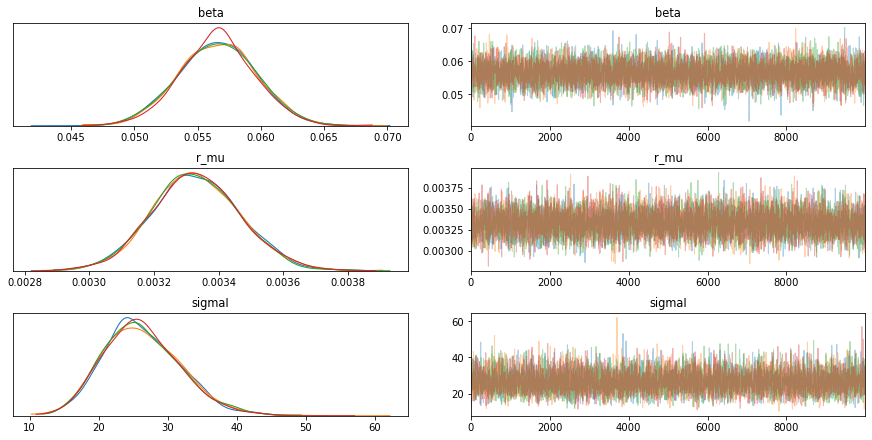

In [169]:
pm.traceplot(trace)

In [191]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta,0.06,0.00,0.05,0.06,0.00,0.00,7304.0,7304.0,7292.0,7925.0,1.0
r_mu,0.00,0.00,0.00,0.00,0.00,0.00,7809.0,7809.0,7786.0,8113.0,1.0
sigmaI,26.34,5.54,16.07,36.41,0.07,0.05,6765.0,6765.0,6576.0,7194.0,1.0


In [203]:
pm.summary(trace).loc['beta']['mean']

0.057

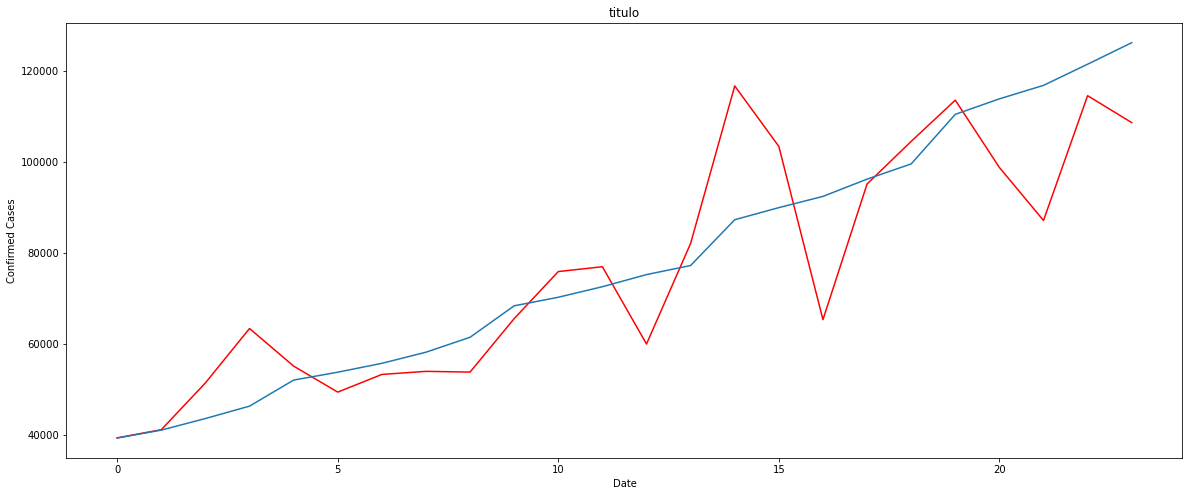

In [171]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(t, np.exp(post_Pred['log_I_obs'][1000].T), color="r", alpha=1)
ax.plot(t,infected)
#ax.set_yscale("log")
ax.set(xlabel="Date", ylabel="Confirmed Cases", title='titulo')
plt.show()

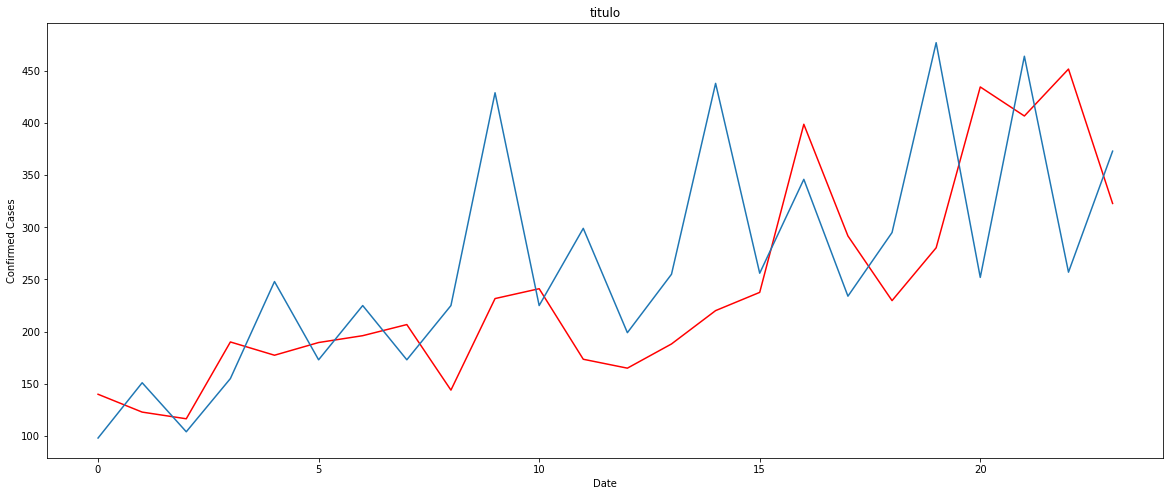

In [172]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(t, np.exp(post_Pred['log_X_obs'][100].T), color="r", alpha=1)
ax.plot(t,X)
#ax.set_yscale("log")
ax.set(xlabel="Date", ylabel="Confirmed Cases", title='titulo')
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe777075940>,
      dtype=object)

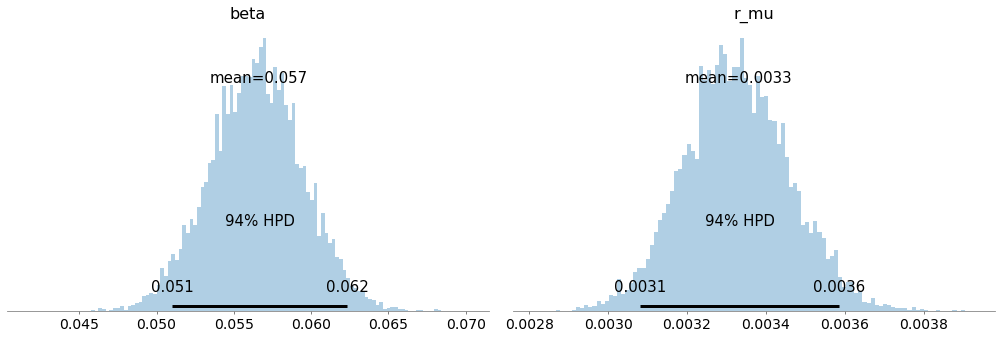

In [216]:
pm.plot_posterior(trace, var_names=(['beta','r_mu']), kind='hist')

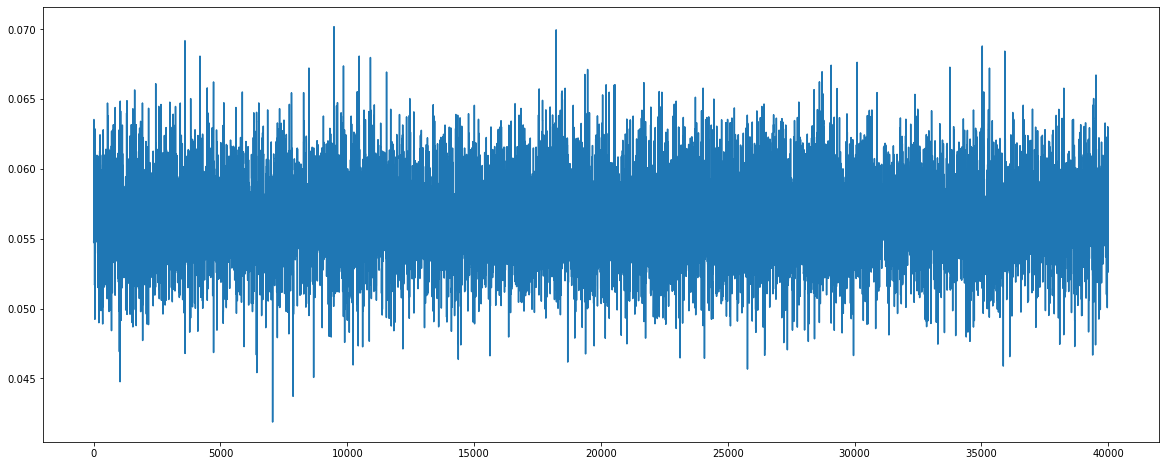

In [174]:
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(trace['beta'])

plt.show()

In [200]:
beta_ = trace['beta'].mean()
r_mu_ = trace['r_mu'].mean()
I_ = infected[0]*np.exp((beta_/r_mu_-1)*r_mu_*t)

In [202]:
beta_

0.056585713158636156

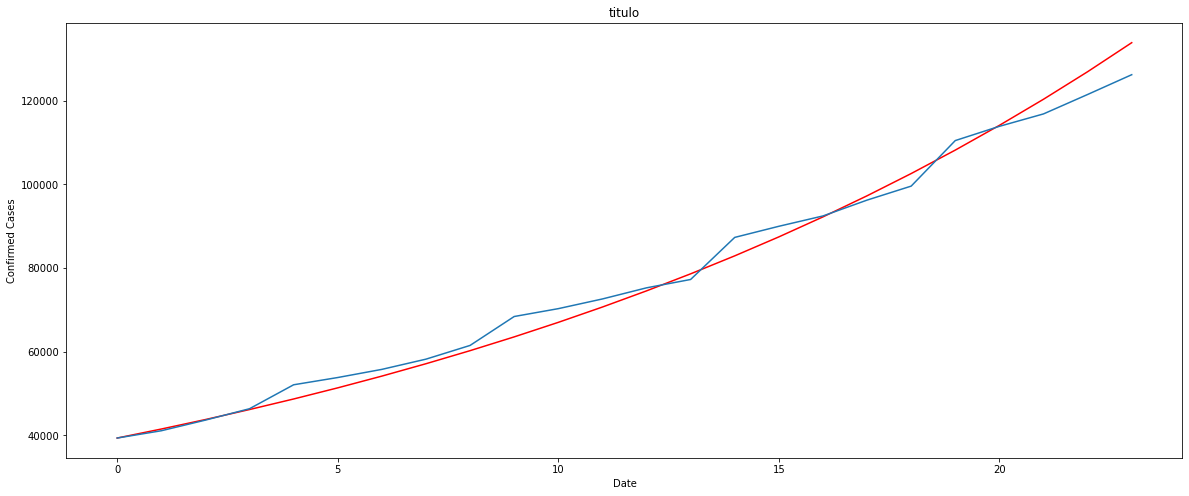

In [176]:
fig, ax = plt.subplots(figsize=(20, 8))
#ax.plot(t, np.exp(post_Pred['log_I_obs'][100].T), color="r", alpha=1)
ax.plot(t,I_,color='r')
ax.plot(t,infected)
#ax.set_yscale("log")
ax.set(xlabel="Date", ylabel="Confirmed Cases", title='titulo')
plt.show()

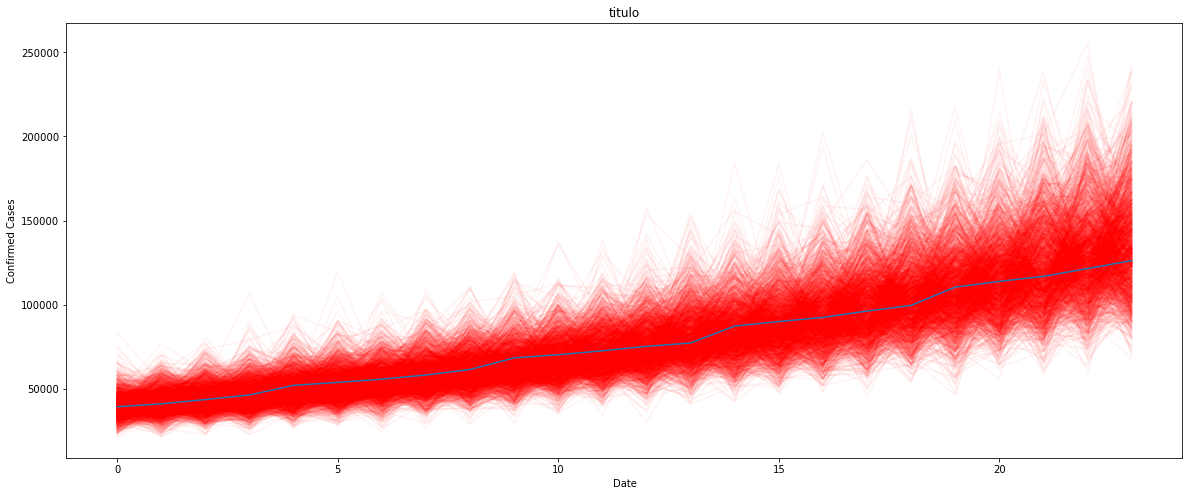

In [218]:
fig, ax = plt.subplots(figsize=(20, 8))
for i in range(2000):
               ax.plot(t, np.exp(post_Pred['log_I_obs'][i].T), color="r", alpha=0.05)
ax.plot(t,infected)
#ax.set_yscale("log")
ax.set(xlabel="Date", ylabel="Confirmed Cases", title='titulo')
plt.show()

In [207]:
beta_sup = pm.summary(trace).loc['beta']['hpd_97%']
beta_inf = pm.summary(trace).loc['beta']['hpd_3%']
r_mu_sup = pm.summary(trace).loc['r_mu']['hpd_97%']
r_mu_inf = pm.summary(trace).loc['r_mu']['hpd_3%']

In [214]:
beta_ = trace['beta'].mean()
r_mu_ = trace['r_mu'].mean()
I_sup = infected[0]*np.exp((beta_sup/r_mu_inf-1)*r_mu_*t)
I_inf = infected[0]*np.exp((beta_inf/r_mu_sup-1)*r_mu_*t)

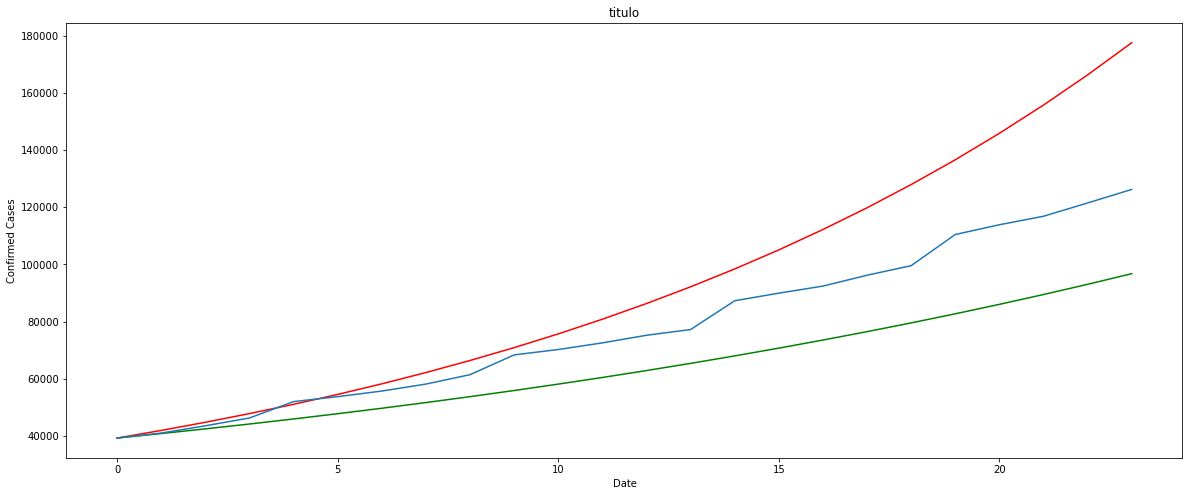

In [215]:
fig, ax = plt.subplots(figsize=(20, 8))
#ax.plot(t, np.exp(post_Pred['log_I_obs'][100].T), color="r", alpha=1)
ax.plot(t,I_sup,color='r')
ax.plot(t,I_inf,color='g')
ax.plot(t,infected)
#ax.set_yscale("log")
ax.set(xlabel="Date", ylabel="Confirmed Cases", title='titulo')
plt.show()